# Поиск сигнальных событий на $\phi$-мезоне

In [213]:
%load_ext autoreload
%autoreload 2

In [219]:
import uproot
import numpy as np
import pandas as pd
import pylib.style as pl

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 120

In [395]:
dfExp = uproot.open('../trees/exp2012omega.root')['t'].pandas.df()
dfMC  = uproot.open('../trees/mc_mcgpj12omega.root')['t'].pandas.df()

In [396]:
dfExp['ebeam'] = dfExp.name.astype(str).str.extract(r'_e(\d+.?\d*)_', expand=False).astype(float)
dfMC['ebeam'] = dfMC.name.astype(str).str.extract(r'_(\d+.?\d*)_', expand=False).astype(float)
dfMC['runnum'] = dfMC.name.astype(str).str.extract(r'_(\d+).root', expand=False).astype(int)

In [397]:
dfMC.loc[dfMC.runnum==17451, 'ebeam'] = 511.1
dfExp.loc[dfExp.ebeam>5000, 'ebeam'] = 511.1
dfExp.drop('name', axis=1, inplace=True)
dfMC.drop('name', axis=1, inplace=True)

In [398]:
dfExp = dfExp.set_index('ebeam')
dfMC = dfMC.set_index('ebeam')

In [400]:
dfExp.index.unique()

Float64Index([507.0, 508.0, 509.0, 510.0, 511.1, 511.0, 512.0, 514.0, 525.0], dtype='float64', name='ebeam')

In [506]:
e0, lum, nMC = 514, 58.9441, 20000
dfE = dfExp.loc[e0]
dfM = dfMC.loc[e0]
phi =  0.205/(e0*2e-3-0.732) + 0.14

In [508]:
dfE.emeas.unique()*2

array([1029.0898], dtype=float32)

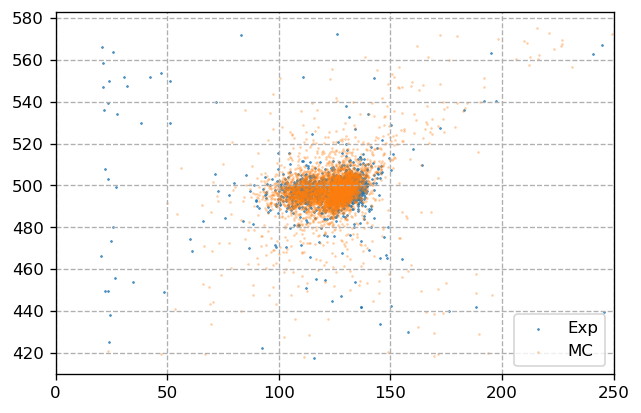

In [509]:
plt.grid(ls='--')
plt.scatter(dfE.ksptot, dfE.ksminv, marker='.', s=1, label='Exp');
plt.scatter(dfM.ksptot, dfM.ksminv, marker='.', s=1, alpha=0.4, label='MC');
plt.xlim(0, 250)
plt.legend();

In [510]:
mKs= 497.6
p0 = np.sqrt(e0**2 - mKs**2)
dfE = dfE.assign(x1=(dfE.ksminv - mKs)*np.cos(phi))
dfE = dfE.assign(x2=(dfE.ksptot - p0)*np.sin(phi))

In [511]:
dfM = dfM.assign(x1=(dfM.ksminv - mKs)*np.cos(phi))
dfM = dfM.assign(x2=(dfM.ksptot - p0)*np.sin(phi))

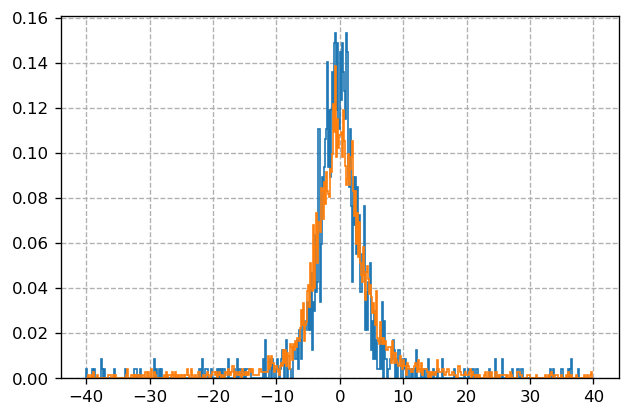

In [512]:
plt.grid(ls='--')
plt.hist(dfE.x1, bins=500, range=(-40, 40), histtype='step', density=True);
plt.hist(dfM.x1, bins=500, range=(-40, 40), histtype='step', density=True);

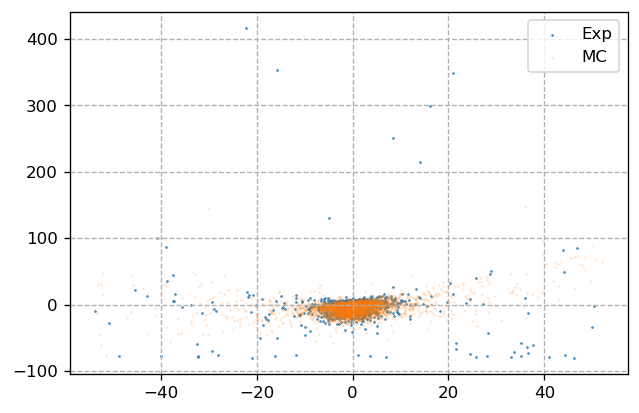

In [513]:
plt.grid(ls='--')
plt.scatter(dfE.x1, dfE.x2, marker='.', s=1, label='Exp');
plt.scatter(dfM.x1, dfM.x2, marker='.', s=1, alpha=0.2, label='MC');
# plt.xlim(0, 250)
plt.legend();

[iminuit notebook](https://nbviewer.ipython.org/github/scikit-hep/iminuit/blob/master/tutorial/cost_functions.ipynb)

In [514]:
import numba as nb
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL, BinnedNLL, ExtendedUnbinnedNLL, ExtendedBinnedNLL, LeastSquares
from argparse import Namespace

In [515]:
width = 80
dt = dfE.x1.values
dt = dt[abs(dt)<width/2]

In [516]:
kwd = {"parallel": False, "fastmath": True}

@nb.njit(**kwd)
def signal_pdf(x, mu, sigma):
    z = (x - mu) / sigma
    invnorm = 1 / ( np.sqrt(2 * np.pi) * sigma )
    signal = np.exp(-(z**2)/2) * invnorm
    return signal

@nb.njit(**kwd)
def norm_pdf(x, mu, sigma1, sigma2, b, f, fs):
    sig1 = signal_pdf(x, mu, sigma1)
    sig2 = signal_pdf(x, mu, sigma2)
    bkg = b/width
    return f*( fs*sig1 + (1-fs)*sig2 ) + (1-f)*bkg

In [517]:
m = Minuit(ExtendedUnbinnedNLL(dt, lambda x, n, mu, sigma1, sigma2, b, f, fs: (n, n * norm_pdf(x, mu, sigma1, sigma2, b, f, fs))),
                       n=1000, mu=0, sigma1=2, sigma2=5, b=1e-5, f=0.99,
                       limit_mu=(-2, 2),
                       limit_sigma1=(0,None),
                       limit_sigma2=(0,None),
                       limit_n=(0, None),
                       limit_b=(0, 1),
                       limit_f=(0, 1),
                       limit_fs=(0, 1),
          )

In [518]:
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -4950                      │       Ncalls = 260 (260 total)       │
│ EDM = 3.14e-05 (Goal: 0.0001)    │               up = 0.5               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n      │ 1.4687e3  │ 0.0014e3  │            │            │    0    │         │       │
│ 1 │ mu     │   -0.09   │   0.09    │            │            │   -2    │    2    │       │
│ 2 │ sigma1 │   2.78    │   0.08    │            │            │    0    │         │       │
│ 3 │ sigma2 │   16.7    │    0.8    │            │            │    0    │         │       │
│ 4 │ b      │    0.0    │    0.7    │            │            │    0    │    1    │       │
│ 5 │ f      │1000.00e-3 │  0.34e-3  │            │            │    0    │    1    │       │
│ 6 │ fs     │   0.854   │   0.014   │            │            │    0    │    1    │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

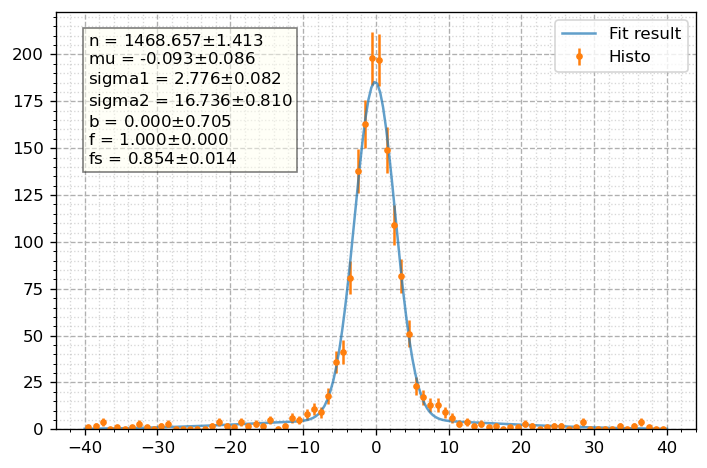

In [519]:
pl.plot_fit(dt, norm_pdf, m, 80, (-40, 40), errors=True, label='Histo')

In [520]:
N0 = (m.values['n'], m.errors['n'])

Эфффективность регистрации

In [521]:
mcdata = dfM.x1.values
mcdata = mcdata[abs(mcdata)<width/2]

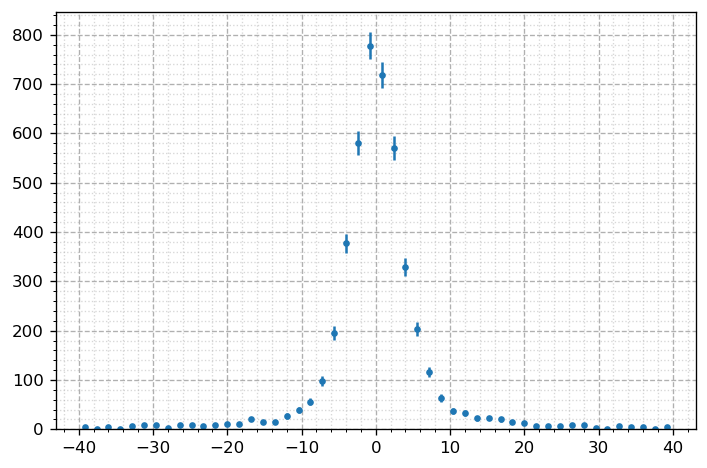

In [522]:
pl.hep_histo(mcdata, 50, (-width/2, width/2))
pl.my_style(ylim=(0, None))

In [523]:
NMC = mcdata.size/20000, np.sqrt(mcdata.size)/20000

In [524]:
NMC

(0.22575, 0.0033596874854664683)

Эффективность триггера

In [525]:
tab = dfE.query('abs(x1)<@width/2')

In [526]:
trigdf = pd.pivot_table( tab[['trigbits']].assign(ones=1), values='ones', columns='trigbits', aggfunc='sum').\
            rename({1: 'T', 2: 'C', 3:'TC'}, axis=1)

In [527]:
t, c, tc = trigdf['T']+trigdf['TC'], trigdf['C']+trigdf['TC'], trigdf['TC']

trigdf['effT'] = (tc + 1)/(c + 2)
trigdf['effC'] = (tc + 1)/(t + 2)

trigdf['errT'] = np.sqrt( (tc+1)*(tc+2)/(c+2)/(c+3) - ((tc+1)/(c+2))**2 )
trigdf['errC'] = np.sqrt( (tc+1)*(tc+2)/(t+2)/(t+3) - ((tc+1)/(t+2))**2 )

trigdf['eff']  = 1 - (1-trigdf.effT)*(1-trigdf.effC)
trigdf['err']  = np.sqrt( (trigdf.errT*(1-trigdf.effC))**2 
                         + (trigdf.errC*(1-trigdf.effT))**2 )

In [528]:
trigdf

trigbits,T,C,TC,effT,effC,errT,errC,eff,err
ones,1177,20,272,0.928571,0.188146,0.014995,0.010257,0.94201,0.012195


In [529]:
effT = trigdf.iloc[0][['eff', 'err']].values

Посмотрим

In [530]:
dfE.index[0]

514.0

In [531]:
dfE.emeas.unique()*2

array([1029.0898], dtype=float32)

In [532]:
# lum, rad, enspr = [58.9441, 0.367584], 0.83, 0.994 #510 MeV
# lum, rad, enspr = [52.9112, 0.347086], 0.72, 1.022 #509 MeV
lum, rad, enspr = [55.5566, 0.359233], 1.26, 0.998 #514 MeV

In [533]:
N0, NMC, effT

((1468.6569986773463, 1.4132469362858728),
 (0.22575, 0.0033596874854664683),
 array([0.94201044, 0.01219539]))

In [542]:
cs = (N0[0]/NMC[0]/effT[0]/lum[0]/rad)*enspr

In [543]:
cs_err = cs*np.sqrt( (N0[1]/N0[0])**2 + (NMC[1]/NMC[0])**2 +
                    (effT[1]/effT[0])**2 )

In [544]:
cs, cs_err

(98.46031993634193, 3.220691567610834)

Результат:

$E_{c.m.}$, MeV | $\sigma$, nb | $\sigma_0$, nb 
--- | --- | ---
1019.214 | 1399.1 $\pm$ 25.3 | 1433.05 $\pm$ 15.03
1021.309 | 805.4 $\pm$ 15.3 | 807.54 $\pm$ 10.36
1029.09 | 98.5 $\pm$ 3.2 | 96.96 $\pm$ 3.00

In [545]:
arr = np.array([
[1019.214, 1399.1, 25.3, 1433.05, 15.03],
[1021.309, 805.4, 15.3, 807.54, 10.36],
[1029.09, 98.5, 3.22, 96.96, 3.00],
]).T

In [546]:
arr

array([[1019.214, 1021.309, 1029.09 ],
       [1399.1  ,  805.4  ,   98.5  ],
       [  25.3  ,   15.3  ,    3.22 ],
       [1433.05 ,  807.54 ,   96.96 ],
       [  15.03 ,   10.36 ,    3.   ]])

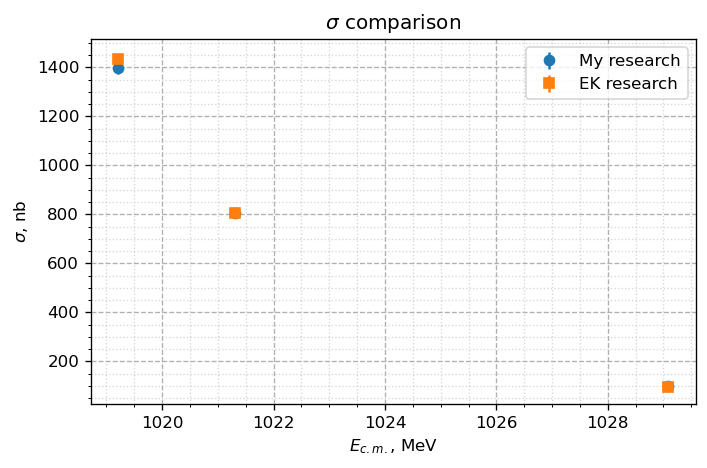

In [547]:
plt.errorbar(arr[0], arr[1], yerr=arr[2], fmt='o', label='My research')
plt.errorbar(arr[0], arr[3], yerr=arr[4], fmt='s', label='EK research')
pl.my_style('$\\sigma$ comparison', '$E_{c.m.}$, MeV', '$\\sigma$, nb', legend=True)